# softmax

In [1]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def get_device_properties(device_id=None):
    import pycuda.driver as cuda
    import pycuda.autoinit
    device = (cuda.Device(device_id) if device_id is not None 
              else torch.cuda.current_device())
    NUM_SM = device.get_attribute(
        cuda.device_attribute.MULTIPROCESSOR_COUNT)
    NUM_REGS = device.get_attribute(
        cuda.device_attribute.MAX_REGISTERS_PER_BLOCK)
    SIZE_SMEM = device.get_attribute(
        cuda.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK)
    WARP_SIZE = device.get_attribute(
        cuda.device_attribute.WARP_SIZE)
    return NUM_SM, NUM_REGS, SIZE_SMEM, WARP_SIZE

## Naive Softmax




In [2]:

def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret


## Triton safe softmax

In [ ]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    # number rows per block = n_rows / row_step
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # Load input
        col_offset = tl.arange(0, BLOCK_SIZE)
        mask = col_offset < n_cols
        input_offset = row_idx * input_row_stride + col_offset
        x = tl.load(input_ptr + input_offset, mask=mask)
        # Pass 1: get max
        x_minus_max = x - tl.max(x, axis=0)
        # Pass 2: allreduce 
        numerator = tl.exp(x_minus_max)
        denominator = tl.sum(numerator, axis=0)
        # Pass 3: compute result
        res = numerator / denominator
        # store result
        output_offset = row_idx * output_row_stride + col_offset
        tl.store(output_ptr + output_offset, res, mask=mask)


In [7]:

NUM_SM, NUM_REGS, SIZE_SMEM, WARP_SIZE = get_device_properties(0)
target = triton.runtime.driver.active.get_current_target()
kernels = {}

def softmax(x):
    n_rows, n_cols = x.shape
    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)
    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        pass
    else: # CUDA
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy
    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)

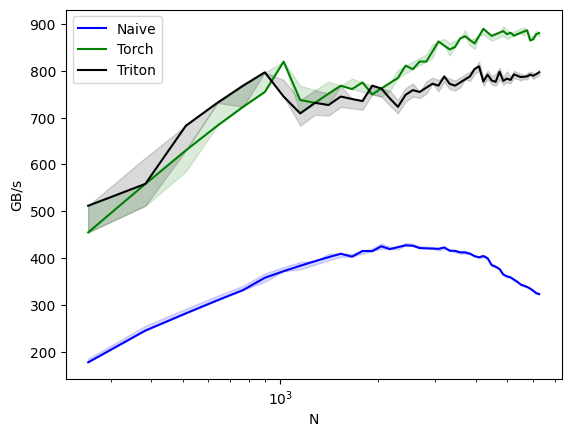

Soft max performance:
         N       Naive       Torch      Triton
0    256.0  178.086953  455.111095  512.000001
1    384.0  245.760006  558.545450  558.545450
2    512.0  282.482752  630.153853  682.666643
3    640.0  310.303028  682.666684  731.428561
4    768.0  332.108094  722.823517  768.000002
5    896.0  358.400009  754.526349  796.444416
6   1024.0  372.363633  819.200021  744.727267
7   1152.0  383.999986  737.280019  708.923085
8   1280.0  393.846158  731.428561  731.428561
9   1408.0  402.285709  750.933352  726.709687
10  1536.0  409.600010  768.000002  744.727267
11  1664.0  403.393936  760.685694  739.555529
12  1792.0  415.536223  774.918885  735.179513
13  1920.0  415.135117  749.268305  768.000019
14  2048.0  425.558458  762.046512  762.046512
15  2176.0  419.469885  773.688877  740.765936
16  2304.0  423.724136  784.340403  722.823543
17  2432.0  427.604388  810.666638  748.307701
18  2560.0  426.666652  803.137269  758.518517
19  2688.0  421.647066  819.443890  75

In [8]:
## benchmark
# ref: https://zhuanlan.zhihu.com/p/23907571699

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 50)],  # Different possible values for `x_name`. `x_name` 的不同可能值。
        x_log=True,  # x axis is logarithmic. x 轴为对数。
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot. 参数名称，其值对应于绘图中的不同线条。
        line_vals=['naive', 'torch', 'triton'],  # Possible values for `line_arg`. `line_arg` 的可能值。
        line_names=['Naive', 'Torch', 'Triton'],  # Label name for the lines. 线条的标签名称。
        styles=[('blue', '-'), ('green', '-'), ('black', '-')],  # Line styles. 线条样式。
        ylabel='GB/s',  # Label name for the y-axis. y 轴标签名称。
        plot_name='Soft max performance',  # Name for the plot. Used also as a file name for saving the plot. 绘图名称。也用作保存绘图的文件名。
        args={'M': 2048},  # Values for function arguments not in `x_names` and `y_name`. 不在 `x_names` 和 `y_name` 中的函数参数值。
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda')
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        softmax(x)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)